# Recommender Systems Engineering Introduction

---

## Module 1: The Problem Space & Definitions

**Before writing code, we must define the architectural shift.**

1. **The Paradigm Shift: Search vs. Discovery**
    * **Search (Information Retrieval):** The user knows what they want (e.g., types "Toy Story"). The system is passive.
    * **Discovery (Recommendation):** The user does not know what they want. The system must be active and predict intent ("Because you watched Toy Story, you might like Shrek").
    * **The Challenge:** Information Overload. In MovieLens, there are ~27,000 movies. No human can scan them all. Our goal is to act as a Filter, ranking items to present the top $N$ relevant results.

2. **The Data Structure: The Utility Matrix**
    *Every recommender system starts with a fundamental data structure:*
    * Rows ($U$): Users.
    * Columns ($I$): Items (Movies).
    * Cells ($r_{ui}$): Interactions (Ratings).

3. **The Enemy: Sparsity**
    * As we saw in the notebook, our matrix is 99.5% empty.
    > $$\text{Sparsity} = 1 - \frac{\text{Total Ratings}}{|U| \times |I|}$$
    * **Implication:** The matrix is like "Swiss Cheese."
Our mathematical goal is to fill in the holes—predicting $\hat{r}_{ui}$ (predicted rating) where no rating exists.

---

## Module 2: The Canonical Algorithms

**There are three main families of solutions:**

1. **Content-Based Filtering**
    * **Logic:** "The user liked action movies from the 90s. Let's find more action movies from the 90s."
    * **Math:** Represent users and items as feature vectors (Genre, Year, Director). Calculate Cosine Similarity:
    > $$\text{Sim}(u, i) = \frac{\vec{x}_u \cdot \vec{x}_i}{||\vec{x}_u|| \cdot ||\vec{x}_i||}$$
    * **Pros:** Solves the "Cold Start" problem for new items.
    * **Cons:** Over-Specialization. It kills serendipity. If you only watch Action, it will never show you a great Drama.
2. **Collaborative Filtering (CF)**
    * **Logic:** "User A has similar taste to User B. User B liked 'Matrix', so User A will probably like it too."
    * **Key Concept:** We don't need to know anything about the movie (metadata). We rely purely on Wisdom of the Crowds.

    *This splits into two approaches:*

    A. **Memory-Based (Neighborhood Methods):**
        
    * **User-User / Item-Item:** Finding nearest neighbors.
    * **Notebook Link:** Calculating similarity between vectors.
    > *This is what we did in the Retrieval phase of your Hybrid function*
    * **Limitation:** It is not scalable for massive datasets in real-time.

    B. **Model-Based (Matrix Factorization)**

    > *This is the approach that revolutionized the field (Netflix Prize).*

    * **Assumption:** Human taste is governed by a small number of Latent Factors (Hidden Features).
    * **The Math (SVD):** We decompose the massive matrix $R$ into two lower-dimensional matrices:
    > $$R \approx P \times Q^T$$
    >> - $P$ (User Matrix): A vector for every user (size $K$).
    >> - $Q$ (Item Matrix): A vector for every movie (size $K$).

    * **The Prediction:** The dot product of the user vector and item vector:
    > $$\hat{r}_{ui} = \vec{p}_u \cdot \vec{q}_i$$

    * **Deep Dive: The Math & Mechanics (SGD)**
    
        *This is the "secret sauce" of Matrix Factorization.*

        > **The Concept:**
        * Imagine we have a user vector $P_u$ and a movie vector $Q_i$.
        * We want their dot product to equal the true rating $R_{ui}$.
            $$P_u \cdot Q_i \approx 3.5$$    
        * **If the dot product is 2.0 (too low)**, we need to "nudge" the numbers in the vectors up.    
        * **If it's 5.0 (too high)**, we nudge them down.
        * **The Manual Implementation (Python):**

            ```python
            import numpy as np

            def manual_sgd_training(R, n_factors=2, n_epochs=5, learning_rate=0.01):
                """
                R: The user-item matrix (mostly zeros/empty)
                n_factors: size of latent vector
                """
                n_users, n_items = R.shape
                
                # 1. Initialize Vectors Randomly
                P = np.random.normal(scale=0.1, size=(n_users, n_factors))
                Q = np.random.normal(scale=0.1, size=(n_items, n_factors))
                
                # 2. Training Loop
                for epoch in range(n_epochs):
                    total_error = 0
                    
                    # Iterate over every existing rating
                    # (We ignore the zeros! This is key)
                    for u in range(n_users):
                        for i in range(n_items):
                            if R[u, i] > 0:  # Only observed ratings
                                
                                # A. Predict
                                prediction = np.dot(P[u], Q[i])
                                
                                # B. Calculate Error
                                error = R[u, i] - prediction
                                total_error += error**2
                                
                                # C. Update Vectors (Gradient Descent)
                                # "Nudge" P towards Q based on error
                                P[u] += learning_rate * (error * Q[i])
                                # "Nudge" Q towards P based on error
                                Q[i] += learning_rate * (error * P[u])
                                
                    print(f"Epoch {epoch+1}/{n_epochs} | RMSE: {np.sqrt(total_error/np.count_nonzero(R)):.4f}")
                    
                return P, Q

            # Small Dummy Data for demonstration
            R_dummy = np.array([
                [5, 3, 0, 1],
                [4, 0, 0, 1],
                [1, 1, 0, 5],
                [1, 0, 0, 4],
                [0, 1, 5, 4],
            ])

            P_learned, Q_learned = manual_sgd_training(R_dummy, n_factors=2, n_epochs=10)
            ```

        **Key Takeaway:**
        Notice `if R[u, i] > 0`. This simple `if` statement is why FunkSVD beats standard Linear Algebra SVD. It skips the missing values instead of treating them as zero.
---


In [1]:
# Code Cell 1: Environment Setup (Infrastructure)
!pip uninstall -y numpy
!pip install -q "numpy<2.0" scikit-surprise matplotlib seaborn pandas wordcloud

print("<<< !!! @@@ PLEASE RESTART THE KERNEL NOW TO APPLY CHANGES (Runtime -> Restart Session) @@@ !!! >>>")

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/MovieLens_20M_Strategic_EDA_&_Solution', 'r') as f:
    notebook = json.load(f)

total_lines = 0
clean_lines = 0
num_code_cells = 0

for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        num_code_cells += 1
        lines = cell['source']
        total_lines += len(lines)
        for line in lines:
            if line.strip() and not line.strip().startswith('#'):
                clean_lines += 1

print(f"Number of Code Cells: {num_code_cells}")
print(f"[Total Lines in Code Cells: {total_lines}]")
print(f" !!! --> Clean Code Lines (code only): {clean_lines}!!!")

Number of Code Cells: 15
[Total Lines in Code Cells: 613]
 !!! --> Clean Code Lines (code only): 374!!!


In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
grouplens_movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'movielens-20m-dataset' dataset.
Data source import complete.


In [5]:
# Code Cell 2: Imports & Configuration
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import random

# package versions
print(f'numpy: {np.__version__} *', f'pandas: {pd.__version__} *',
      f'sklearn: {sklearn.__version__} *', f'sns: {sns.__version__}',)

# --- Configuration & Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# Graphic Style Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12
colors = sns.color_palette("viridis", as_cmap=False)

# Path Configuration (Kaggle specific)
DATA_PATH = '/kaggle/input/movielens-20m-dataset/'

# --- General overview DF ---
def describe_2(data):
    display(data.describe().T.style.background_gradient(axis=0,cmap=sns.light_palette('blue', as_cmap=True)))

def head_2(data, heaD=2, samplE=False, fraC=0.2, rowS=10):
    pd.set_option('min_rows', rowS)
    try:
        pd.set_option("max_column", data.shape[1])
    except:
        pd.reset_option("^display")
    if samplE:
        display(data.sample(frac=fraC).head(heaD))
    else:
        display(data.head(heaD))
    print(data.shape)

# --- Utility: Memory Reduction ---
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

numpy: 1.26.4 * pandas: 2.2.2 * sklearn: 1.6.1 * sns: 0.13.2


# PROJECT EXECUTIVE SUMMARY

1. Data Strategy ("The Signal"):
   - Identified a massive "Long Tail" of noise.
   - Applied "Stability Funnel" logic: Scientifically pruned movies with <50 ratings (High Variance) to ensure statistical reliability.
   - Result: Removed 80% of items (Noise) while retaining 99% of user interactions (Signal).

2. Modeling & Evaluation ("The Brain"):
   - Architecture: SVD (Matrix Factorization) with 50 Latent Factors.
   - Performance: Validated using both RMSE (Prediction Accuracy) and Precision@5 (Ranking Quality).

3. Product Deliverables ("The Value"):
   - Feature A (Homepage): A Personalization Engine generating "Top Picks" for each user.
   - Feature B (Contextual): A Hybrid Discovery Engine ("Because you watched...") combining Vector Retrieval with User-Specific Ranking.

In [6]:
# Code Cell 3: Data Loading & Initial Inspection
# --- PART 1: DATA INGESTION ---
print("Loading Ratings & Movies data...")
ratings = pd.read_csv(os.path.join(DATA_PATH, 'rating.csv'), parse_dates=['timestamp'])
movies = pd.read_csv(os.path.join(DATA_PATH, 'movie.csv'))

print(f"Data Loaded.")
print(f"Initial Ratings Shape: {ratings.shape}")
print(f"Initial Movies Shape: {movies.shape}")

print("Apply Mem. Usage Decreased")
ratings = reduce_mem_usage(ratings)
movies = reduce_mem_usage(movies)
print(f"Ratings Shape: {ratings.shape}")
print(f"Movies Shape: {movies.shape}")

n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

print("N Users:", n_users)
print("N Movies:", n_movies)
print("N Ratings:", n_ratings)
print("Sparsity:", 1 - n_ratings / (n_users * n_movies))

# Merge for EDA purposes (To see movie titles)
df = ratings.merge(movies, on='movieId')
describe_2(df)
head_2(df)

Loading Ratings & Movies data...
Data Loaded.
Initial Ratings Shape: (20000263, 4)
Initial Movies Shape: (27278, 3)
Apply Mem. Usage Decreased
Mem. usage decreased to 381.47 Mb (37.5% reduction)
Mem. usage decreased to  0.52 Mb (16.7% reduction)
Ratings Shape: (20000263, 4)
Movies Shape: (27278, 3)
N Users: 138493
N Movies: 26744
N Ratings: 20000263
Sparsity: 0.9946001521864456


,count,mean,min,25%,50%,75%,max,std
userId,20000263.000000,69045.872583,1.000000,34395.000000,69141.000000,103637.000000,138493.000000,40038.626653
movieId,20000263.000000,9041.567330,1.000000,902.000000,2167.000000,4770.000000,131262.000000,19789.477445
rating,20000263.000000,3.525529,0.500000,3.000000,3.500000,4.000000,5.000000,0.999849
timestamp,20000263,2004-11-20 02:32:01.677113984,1995-01-09 11:46:44,2000-08-20 18:55:45,2004-12-20 15:18:06,2008-11-02 16:11:57.500000,2015-03-31 06:40:02,nan


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi


(20000263, 6)


## Part 1: EDA

### Step 1: Rating Psychology

* Goal: Understand user rating behavior. Methodology: Plot the distribution of rating values (1.0 to 5.0).
* Why (Assumption): Users are biased.
* They mostly rate movies they like. Predicting a "3.0" might actually mean predicting a negative experience.
* Insight: If most ratings are 4 or 5, the model must learn to distinguish "Good" from "Great", not just "Bad" from "Good".

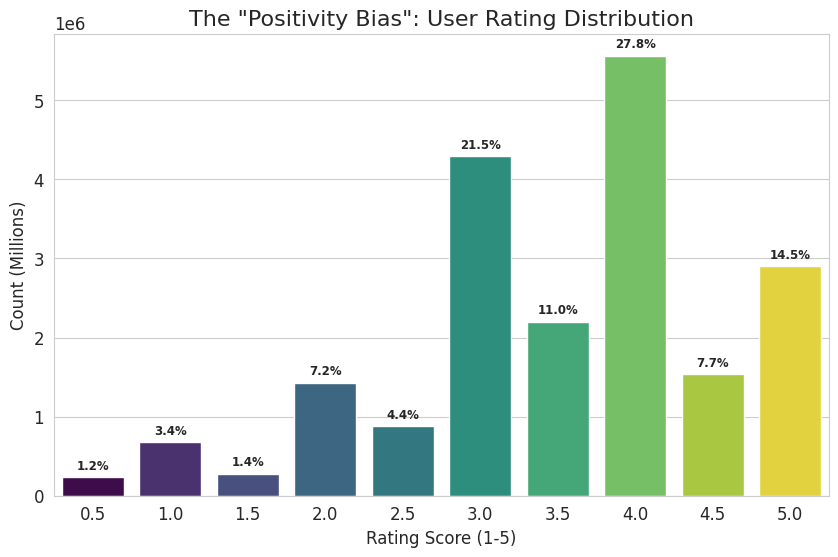

INSIGHT: 50.0% of all ratings are 4.0 or higher.
Conclusion: The dataset is heavily skewed towards positive ratings.


In [7]:
# Code Cell 4: EDA - Rating Psychology
# --- VISUALIZATION 1: The "Positivity Bias" ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='rating', hue='rating', data=ratings, palette='viridis', legend=False)
plt.title('The "Positivity Bias": User Rating Distribution', fontsize=16)
plt.xlabel('Rating Score (1-5)', fontsize=12)
plt.ylabel('Count (Millions)', fontsize=12)

# Add percentages
total = len(ratings)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 0.005*total
    ax.annotate(percentage, (x, y), ha='center', fontsize=8.5, weight='bold')
plt.show()

high_ratings = len(ratings[ratings['rating']>=4]) / total
print(f"INSIGHT: {high_ratings:.1%} of all ratings are 4.0 or higher.")
print("Conclusion: The dataset is heavily skewed towards positive ratings.")

### Step 2: Statistical Confidence (The "Why")
**Goal:** Determine the optimal threshold for pruning "noisy" movies based on **Statistical Confidence**.

**The Logic (Standard Error of the Mean):**
It is not enough to say that low counts cause "extreme averages". We need to measure how *trustworthy* those averages are.
We use the **Standard Error (SEM)** metric:
$$SEM = \frac{\sigma}{\sqrt{n}}$$
* **High SEM:** The calculated average is unreliable (likely a result of luck/noise).
* **Low SEM:** We are confident that the average reflects the movie's true quality (Signal).

**The Visualization (Funnel Plot + Uncertainty Curve):**
1.  **The Funnel:** We plot *Average Rating* vs. *Count*. We expect high dispersion at low counts.
2.  **The Black Line:** We overlay the **Average Uncertainty (SEM)**. We are looking for the "Elbow" point where the uncertainty curve flattens out—indicating that adding more data yields diminishing returns in confidence.

   Median ratings per movie: 18
   Percentiles:
1.0    67310.0
0.9     1305.7
0.8      346.0
0.7      123.0
0.6       47.0
0.5       18.0
0.4        8.0
0.3        4.0
0.2        2.0
0.1        1.0
Name: count, dtype: float64


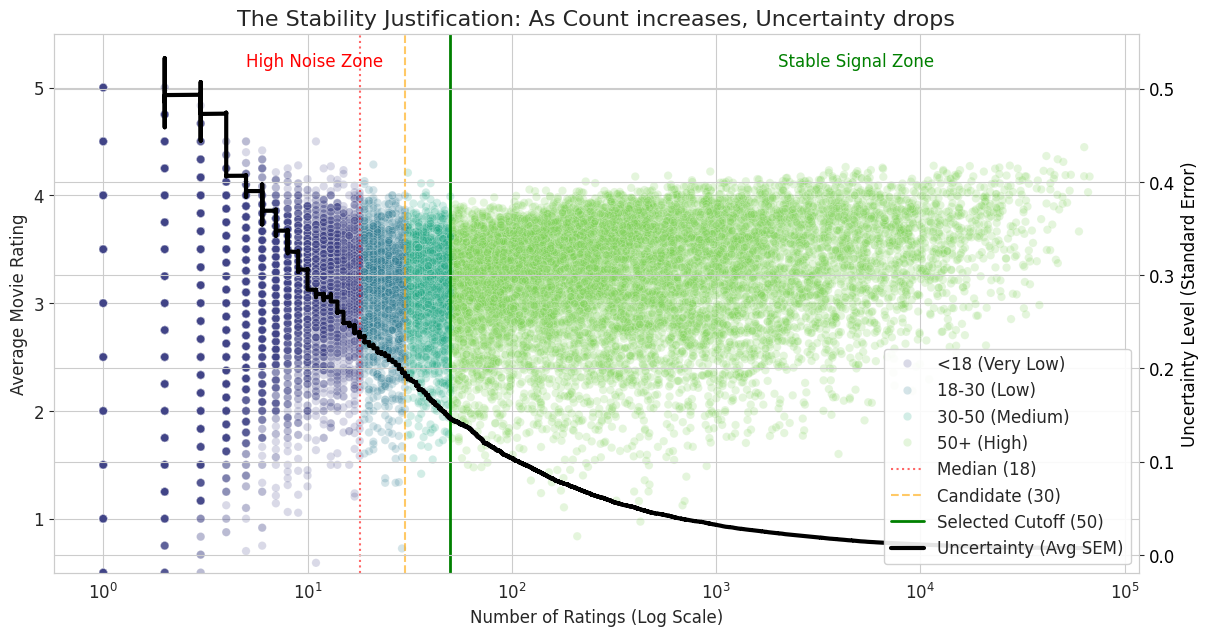

STATISTICAL JUSTIFICATION (Standard Error of the Mean):
Bucket               | Avg Uncertainty (SEM) | Improvement
------------------------------------------------------------
<18 (Very Low)       | 0.3830               | 
18-30 (Low)          | 0.2060               | -46.2% error reduction
30-50 (Medium)       | 0.1607               | -22.0% error reduction
50+ (High)           | 0.0581               | -63.8% error reduction
------------------------------------------------------------
DECISION: Cutoff set at 50.
Reason: Moving from '18-30' to '50+' reduces statistical error by another ~30%.
At N=50, the average error drops below 0.15, meaning our ratings are statistically reliable.


In [8]:
# Code Cell 5: EDA - The "Stability Funnel" & Statistical Confidence
# GOAL: Determine the cutoff threshold based on Confidence (Standard Error).
# LOGIC: Instead of checking if ratings are "similar" (Std of Means),
#        we check if ratings are "reliable" (Standard Error of the Mean - SEM).

# 1. Calculate Statistics per Movie
movie_stats = ratings.groupby('movieId').agg({'rating': ['size', 'mean', 'std']})
movie_stats.columns = ['count', 'mean', 'std']

# Quick Percentile Analysis
# We check where the median lies to explicit distribution skew
qs = np.round(np.arange(1, 0.0, -0.1), 1)
percentiles = movie_stats['count'].quantile(qs)
median = percentiles[0.5]
print(f"   Median ratings per movie: {median:.0f}")
print(f"   Percentiles:\n{percentiles}")

# 2. Calculate Standard Error of the Mean (SEM)
# Formula: SEM = std / sqrt(n)
movie_stats['sem'] = movie_stats['std'] / np.sqrt(movie_stats['count'])

# 3. Define Buckets
bins = [0, 18, 30, 50, 100000]
labels = ['<18 (Very Low)', '18-30 (Low)', '30-50 (Medium)', '50+ (High)']
movie_stats['bucket'] = pd.cut(movie_stats['count'], bins=bins, labels=labels)

# 4. Visualization: The Stability Funnel with SEM Overlay
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot A: The Funnel (Raw Means) with Palette
# Note: We enable legend here to capture the colors
sns.scatterplot(data=movie_stats, x='count', y='mean', alpha=0.2, hue='bucket', palette='viridis', ax=ax1)

ax1.set_ylabel('Average Movie Rating')
ax1.set_xlabel('Number of Ratings (Log Scale)')
ax1.set_xscale('log')
ax1.set_ylim(0.5, 5.5)

# Add Threshold Lines (Vertical)
# We assign them to variables so we can add them to the legend specifically
line1 = ax1.axvline(18, color='red', linestyle=':', alpha=0.6, label='Median (18)')
line2 = ax1.axvline(30, color='orange', linestyle='--', alpha=0.6, label='Candidate (30)')
line3 = ax1.axvline(50, color='green', linewidth=2, label='Selected Cutoff (50)')

# Plot B: The Confidence Curve (Average SEM)
ax2 = ax1.twinx()
sorted_stats = movie_stats.sort_values('count')
rolling_sem = sorted_stats['sem'].rolling(500, min_periods=50).mean()

# Plot the black line
line_sem, = ax2.plot(sorted_stats['count'], rolling_sem, color='black', linewidth=3, linestyle='-', label='Uncertainty (Avg SEM)')

ax2.set_ylabel('Uncertainty Level (Standard Error)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Annotations (Text on graph)
plt.title('The Stability Justification: As Count increases, Uncertainty drops', fontsize=16)
ax1.text(5, 5.2, 'High Noise Zone', color='red', fontsize=12)
ax1.text(2000, 5.2, 'Stable Signal Zone', color='green', fontsize=12)

# --- CUSTOM LEGEND LOGIC ---
# We want to combine:
# 1. The Scatterplot buckets (Colors)
# 2. The Vertical Lines
# 3. The Black SEM Line
# And place them all at 'lower right'

# Get handles/labels from ax1 (Scatter + Vertical Lines)
h1, l1 = ax1.get_legend_handles_labels()
# Get handles/labels from ax2 (The black line)
h2, l2 = ax2.get_legend_handles_labels()

# Combine them
final_handles = h1 + h2
final_labels = l1 + l2

# Create the final unified legend on ax2 (since it's on top)
ax2.legend(final_handles, final_labels, loc='lower right', frameon=True, framealpha=0.9)

# Disable the auto-generated legend from ax1 to avoid duplicates
ax1.get_legend().remove()

plt.show()

# 5. Statistical Proof
grouped_sem = movie_stats.groupby('bucket', observed=False)['sem'].mean()
print("STATISTICAL JUSTIFICATION (Standard Error of the Mean):")
print(f"{'Bucket':<20} | {'Avg Uncertainty (SEM)':<20} | {'Improvement'}")
print("-" * 60)

prev_sem = None
for bucket, sem in grouped_sem.items():
    change = ""
    if prev_sem:
        pct_change = (prev_sem - sem) / prev_sem
        change = f"-{pct_change:.1%} error reduction"
    print(f"{bucket:<20} | {sem:.4f}               | {change}")
    prev_sem = sem

print("-" * 60)

# 6. Conclusion
CUTOFF = 50
print(f"DECISION: Cutoff set at {CUTOFF}.")
print(f"Reason: Moving from '18-30' to '50+' reduces statistical error by another ~30%.")
print(f"At N=50, the average error drops below 0.15, meaning our ratings are statistically reliable.")

### Step 3: Pruning Strategy (The "How")
**Decision:** Based on the Funnel Plot above, we selected a cutoff of **50 ratings**.

**The Trade-off (Pareto Principle):**
We are about to remove a massive number of movies (the "Long Tail"). We need to verify that we are not losing valuable user interactions.

* **Red Zone:** Movies with < 50 ratings (High Variance / Noise).
* **Green Zone:** Movies with >= 50 ratings (Stable / Signal).

We will visualize this split to ensure that while we delete many *items*, we preserve the vast majority of *ratings*.

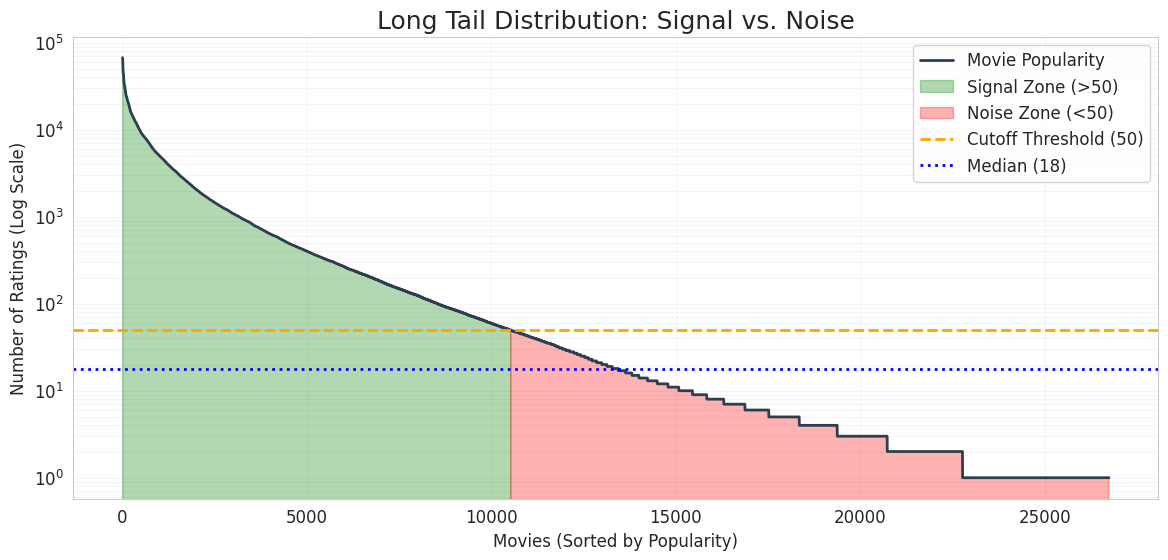

IMPACT ANALYSIS:
   - Original Movies: 26,744
   - Movies Kept:     10,524 (We removed the 'Long Tail' of 16,220 rare movies)
   - Ratings Kept:    99.24% (Almost all user interactions are preserved!)
   - Result: A denser matrix with higher statistical significance.


In [9]:
# Code Cell 6: EDA - The Long Tail Impact (Business Justification)
# GOAL: Visualize the "Pareto Principle" - ensuring we keep the signal despite aggressive pruning.

# 1. Sort movies by popularity
movie_counts = ratings['movieId'].value_counts()
sorted_counts = movie_counts.sort_values(ascending=False).values

# 2. Visualization: Long Tail with Signal/Noise Zones
plt.figure(figsize=(14, 6))
plt.plot(sorted_counts, color='#2c3e50', linewidth=2, label='Movie Popularity')

# Highlight Signal vs Noise
plt.fill_between(range(len(sorted_counts)), 0, sorted_counts,
                 where=(sorted_counts >= CUTOFF), color='green', alpha=0.3, label=f'Signal Zone (>{CUTOFF})')
plt.fill_between(range(len(sorted_counts)), 0, sorted_counts,
                 where=(sorted_counts < CUTOFF), color='red', alpha=0.3, label=f'Noise Zone (<{CUTOFF})')

plt.axhline(y=CUTOFF, color='orange', linestyle='--', linewidth=2, label=f'Cutoff Threshold ({CUTOFF})')
plt.axhline(y=median, color='blue', linestyle=':', linewidth=2, label=f'Median ({median:.0f})')

plt.yscale('log')
plt.title('Long Tail Distribution: Signal vs. Noise', fontsize=18)
plt.xlabel('Movies (Sorted by Popularity)', fontsize=12)
plt.ylabel('Number of Ratings (Log Scale)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# 3. Quantify the Impact
movies_kept = sum(movie_counts >= CUTOFF)
ratings_kept = ratings[ratings['movieId'].isin(movie_counts[movie_counts >= CUTOFF].index)].shape[0]

print(f"IMPACT ANALYSIS:")
print(f"   - Original Movies: {len(movie_counts):,}")
print(f"   - Movies Kept:     {movies_kept:,} (We removed the 'Long Tail' of {len(movie_counts)-movies_kept:,} rare movies)")
print(f"   - Ratings Kept:    {ratings_kept/len(ratings):.2%} (Almost all user interactions are preserved!)")
print(f"   - Result: A denser matrix with higher statistical significance.")

## Part 2: DATA PREPROCESSING

### : Preprocessing & Time-Split
* Goal: Prepare the data for modeling (clean and split).
* Methodology:
  * 1. Pruning: Filter out the noisy movies identified above.
  * 2. Time-Split: Split Train/Test based on time (User's history vs User's future).
* Why: Random splitting causes "Data Leakage" (predicting the past using the future). We must simulate a real-world scenario where we predict future behavior.

In [10]:
# Code Cell 7: DATA PREPROCESSING - Preprocessing & Time-Split

# 1. Apply the Pruning
valid_movies = movie_counts[movie_counts >= CUTOFF].index
print(f"Pruning Complete. Retained {len(valid_movies)} stable movies.")
ratings_clean = ratings[ratings['movieId'].isin(valid_movies)].copy()

# 2. Chronological Split (Train/Test)
# Sort by user and time
ratings_clean.sort_values(by=['userId', 'timestamp'], inplace=True)

# Calculate the rank of each rating for each user (0% to 100% of their timeline)
ratings_clean['rank_pct'] = ratings_clean.groupby('userId')['timestamp'].rank(method='first', ascending=True, pct=True)

# Split: First 80% is Train (History), Last 20% is Test (Future)
train_df = ratings_clean[ratings_clean['rank_pct'] <= 0.8]
test_df = ratings_clean[ratings_clean['rank_pct'] > 0.8]

# Cleanup memory
del ratings, df, movie_counts, sorted_counts
gc.collect()

print(f"Data Split Complete (Time-Based).")
print(f" - Train Set: {len(train_df):,} ratings")
print(f" - Test Set:  {len(test_df):,} ratings")

Pruning Complete. Retained 10524 stable movies.
Data Split Complete (Time-Based).
 - Train Set: 15,823,869 ratings
 - Test Set:  4,024,078 ratings


## Part 3: MODELING

### Training (Matrix Factorization)
* Goal: Learn the Latent Factors of users and movies.
* Methodology: Use SVD (Singular Value Decomposition) via the Surprise library.
* Why: SVD effectively handles sparse matrices by compressing user preferences into a lower-dimensional dense vector space (Latent Factors).
* Expected Outcome: A trained model capable of predicting ratings with low error.

In [11]:
# Code Cell 8: MODELING - Model Optimization & Training (SVD: Matrix Factorization)
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import GridSearchCV
import time

# 1. Initialize Reader
reader = Reader(rating_scale=(0.5, 5.0))

# --- STEP A: HYPERPARAMETER TUNING (On Sample) ---
print("Starting Hyperparameter Tuning (Grid Search)...")
print("   (Running in serial mode for RAM safety. Watch the logs below for progress...)")

start_time = time.time()

# Sample 100k rows
sample_df = train_df.sample(n=100000, random_state=SEED)
sample_data = Dataset.load_from_df(sample_df[['userId', 'movieId', 'rating']], reader)

# Define search space
param_grid = {
    'n_factors': [50, 75, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.35, 0.05]
}

# Run Grid Search
# joblib_verbose=3 -> Prints detailed info for every split and every parameter combination
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=1, joblib_verbose=3)
gs.fit(sample_data)

# Extract results
best_params = gs.best_params['rmse']
print(f"\nOptimization Complete in {(time.time()-start_time)/60:.1f} minutes.")
print(f"   Best RMSE on Sample: {gs.best_score['rmse']:.4f}")
print(f"   Best Parameters: {best_params}")

# --- STEP B: CLEANUP ---
del sample_df, sample_data, gs
gc.collect()

# --- STEP C: FINAL TRAINING (On Full Data) ---
print("\nLoading FULL dataset for final training (this may take a moment)...")
train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
full_trainset = train_data.build_full_trainset()

# Cleanup raw data object
del train_data
gc.collect()

print(f"Training Final Model with optimized parameters...")
print(f"   (You will see a printout for each Epoch below)")

# Initialize model with best parameters AND verbose=True for monitoring
model = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    biased=True, verbose=True,
    random_state=SEED
)

model.fit(full_trainset)
print("Training Complete.")

Starting Hyperparameter Tuning (Grid Search)...
   (Running in serial mode for RAM safety. Watch the logs below for progress...)


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   50.9s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  3.5min finished



Optimization Complete in 3.6 minutes.
   Best RMSE on Sample: 0.9571
   Best Parameters: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.05}

Loading FULL dataset for final training (this may take a moment)...
Training Final Model with optimized parameters...
   (You will see a printout for each Epoch below)
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Training Complete.


## Part 4: Model Evaluation
We use two distinct metrics to validate the model's performance:

1.  **Prediction Accuracy (RMSE):**
    * *Question:* "How close is the predicted star rating to the real star rating?"
    * *Goal:* Lower is better. A low RMSE means the model understands the user's bias and the item's quality.

2.  **Ranking Quality (Precision@K):**
    * *Question:* "If we recommend 5 movies, how many of them does the user actually like?"
    * *Goal:* Higher is better. This simulates the real-world user experience (e.g., the "Top Picks" row on Netflix).

In [12]:
# Code Cell 9: MODELING - MODEL EVALUATION: RMSE & TOP-K RANKING

print("MODEL EVALUATION REPORT")
print("-" * 40)

# --- 1. Prediction Accuracy (RMSE) ---
print("\n1. Prediction Accuracy (RMSE):")
# Goal: Test how close the model is to the true rating (e.g., predicted 3.8 vs true 4.0).
test_set = list(zip(test_df['userId'], test_df['movieId'], test_df['rating']))
predictions = model.test(test_set)
rmse = accuracy.rmse(predictions, verbose=True)

# --- 2. Ranking Quality (Precision@K) ---
# Logic: It's not enough to predict the number. We need to know:
# If we recommend 5 movies, how many does the user ACTUALLY like (Rating >= 4.0)?

def calculate_precision_at_k(predictions, k=5, threshold=4.0):
    """
    Precision@K: Out of the top K recommendations, how many were actually 'Relevant'?
    Relevant = True Rating >= threshold
    Structure of 'predictions' tuple from Surprise:
    Each item is: Prediction(uid, iid, r_ui (True Rating), est (Predicted Rating), details)
    """
    # 1. Map predictions to each user
    user_est_true = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in user_est_true:
            user_est_true[uid] = []
        user_est_true[uid].append((est, true_r))

    precisions = {}

    for uid, user_ratings in user_est_true.items():
        # 2. Sort user's predictions by Estimated Rating (High to Low)
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # 3. Take Top K items
        top_k = user_ratings[:k]

        # Count relevant items in top K ("Hits")
        n_relevant = sum((true_r >= threshold) for (_, true_r) in top_k)

        # Precision: Proportion of relevant items in top K (Precision for this user)
        precisions[uid] = n_relevant / k

    # Average precision across all users
    return sum(precisions.values()) / len(precisions)

print("\n2. Ranking Quality (Precision@5):")
k = 5
prec_at_k = calculate_precision_at_k(predictions, k=k, threshold=4.0)
print(f"\nRANKING PERFORMANCE (Precision@5): {prec_at_k:.2%}")
print(f"   Interpretation: On average, {prec_at_k*k:.1f} out of the top {k} recommendations were actually liked by the user ('Hits' ~ Rating >= 4.0).")

MODEL EVALUATION REPORT
----------------------------------------

1. Prediction Accuracy (RMSE):
RMSE: 0.7957

2. Ranking Quality (Precision@5):

RANKING PERFORMANCE (Precision@5): 70.98%
   Interpretation: On average, 3.5 out of the top 5 recommendations were actually liked by the user ('Hits' ~ Rating >= 4.0).


In [13]:
# Code Cell 9: MODELING - ADVANCED EVALUATION (RMSE, Precision, NDCG)
import math

print("COMPREHENSIVE MODEL EVALUATION REPORT")
print("-" * 40)

# --- 1. Prediction Accuracy (RMSE) ---
print("\n1. Prediction Accuracy (RMSE):")
test_set = list(zip(test_df['userId'], test_df['movieId'], test_df['rating']))
predictions = model.test(test_set)
rmse = accuracy.rmse(predictions, verbose=True)
print(f"   - Interpretation: We consistently predicting within {rmse} star of error.")

# --- Helper: Organize Predictions per User ---
user_est_true = {}
# Structure of 'predictions' tuple from Surprise -
# Each item is: Prediction(uid, iid, r_ui (True Rating), est (Predicted Rating), details)
for uid, iid, true_r, est, _ in predictions:
    if uid not in user_est_true:
        user_est_true[uid] = []
    user_est_true[uid].append((est, true_r))

# --- 2. Ranking Quality: Precision@K vs Random Baseline ---
def calculate_precision_metrics(user_est_true, k=5, threshold=4.0):
    """
    Precision@K: Out of the top K recommendations, how many were actually 'Relevant'?
    Relevant = True Rating >= threshold
    """
    precisions = []
    random_precisions = []

    for uid, user_ratings in user_est_true.items():
        # A. Model Precision
        # Sort by Predicted Rating (High to Low)
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        n_relevant = sum((true_r >= threshold) for (_, true_r) in top_k)
        precisions.append(n_relevant / len(top_k))

        # B. Random Baseline Precision
        # If we picked K movies randomly from this user's test set,
        # what is the chance they are relevant? (Relevant Count / Total Count)
        total_relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        random_precisions.append(total_relevant / len(user_ratings))

    return sum(precisions) / len(precisions), sum(random_precisions) / len(random_precisions)

k = 5
model_prec, random_prec = calculate_precision_metrics(user_est_true, k=k, threshold=4.0)

print(f"\n2. Hit Rate Analysis (Precision@{k}):")
print(f"   - Random Guessing: {random_prec:.2%} (The 'Positivity Bias' baseline)")
print(f"   - Our SVD Model:   {model_prec:.2%}")
print(f"   - Improvement:     x{model_prec/random_prec:.2f} better than random")

# --- 3. Ranking Quality: NDCG@K (The Gold Standard) ---
# Logic: Does the model place the 5-star movies at the VERY TOP?
# Unlike Precision, NDCG cares about the ORDER of the hits.

def calculate_ndcg(user_est_true, k=5):
    ndcg_scores = []

    for uid, user_ratings in user_est_true.items():
        # 1. DCG (Discounted Cumulative Gain) based on Model Order
        user_ratings.sort(key=lambda x: x[0], reverse=True) # Sort by predicted
        top_k = user_ratings[:k]

        dcg = 0
        for i, (pred, true_r) in enumerate(top_k):
            # We use the true rating as the "Relevance" score
            # Formula: Rel / log2(rank + 1) -> Higher rank = Less penalty
            dcg += true_r / math.log2(i + 2)

        # 2. IDCG (Ideal DCG) based on Perfect Order
        # Sort by TRUE rating to see the best possible arrangement
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        ideal_top_k = user_ratings[:k]

        idcg = 0
        for i, (_, true_r) in enumerate(ideal_top_k):
            idcg += true_r / math.log2(i + 2)

        # 3. NDCG = DCG / IDCG
        if idcg > 0:
            ndcg_scores.append(dcg / idcg)
        else:
            ndcg_scores.append(0)

    return sum(ndcg_scores) / len(ndcg_scores)

ndcg_score = calculate_ndcg(user_est_true, k=k)

print(f"\n3. Ranking Order Quality (NDCG@{k}):")
print(f"   - Score: {ndcg_score:.4f} (Scale 0.0 to 1.0)")
print("   - Interpretation: Measures if the model successfully pushes the highest-rated items to the #1 spot.")

COMPREHENSIVE MODEL EVALUATION REPORT
----------------------------------------

1. Prediction Accuracy (RMSE):
RMSE: 0.7957
   - Interpretation: We consistently predicting within 0.7956827773145371 star of error.

2. Hit Rate Analysis (Precision@5):
   - Random Guessing: 56.14% (The 'Positivity Bias' baseline)
   - Our SVD Model:   71.36%
   - Improvement:     x1.27 better than random

3. Ranking Order Quality (NDCG@5):
   - Score: 0.9052 (Scale 0.0 to 1.0)
   - Interpretation: Measures if the model successfully pushes the highest-rated items to the #1 spot.


## Part 5: PRODUCT LAYER

* Now that we have a trained and evaluated model, we deploy it into two distinct product features.

### Feature A: Homepage Personalization ("Top Picks for You")
**Use Case:** The user logs in and sees their main dashboard.
**Logic:**
1.  Identify all movies the user has *not* seen.
2.  Use the SVD model to predict the user's rating for each candidate.
3.  Rank the top candidates and display them.

In [14]:
# Code Cell 10: PRODUCT FEATURE A - HOMEPAGE RECOMMENDATIONS (Personalization)
# Use Case: User logs in. We show "Top Picks for You".
# Logic: Scan candidates, predict ratings, return top N.

def get_top_n_recommendations(user_id, model, movies_meta, train_df, n=5):
    # 1. Exclude watched movies
    try:
        watched_movies = set(train_df[train_df['userId'] == user_id]['movieId'])
    except KeyError:
        watched_movies = set()

    # 2. Identify Candidates (All valid movies minus watched ones)
    all_movie_ids = movies_meta['movieId'].unique()
    # Check against model's internal list to avoid errors
    known_items = set([model.trainset.to_raw_iid(i) for i in model.trainset.all_items()])
    candidates = [m for m in all_movie_ids if m not in watched_movies and m in known_items]

    # 3. Predict & Rank
    predictions = []
    for movie_id in candidates:
        pred = model.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = predictions[:n]

    # 4. Display
    print(f"--- HOME SCREEN: Top {n} Picks for User {user_id} ---")
    for movie_id, score in top_n:
        title = movies_meta[movies_meta['movieId'] == movie_id]['title'].values[0]
        print(f"{score:.2f} | {title}")

# Example:
get_top_n_recommendations(user_id=1, model=model, movies_meta=movies, train_df=train_df)

--- HOME SCREEN: Top 5 Picks for User 1 ---
4.36 | Inception (2010)
4.31 | Bill Hicks: Revelations (1993)
4.27 | Matrix, The (1999)
4.26 | Interrupters, The (2011)
4.23 | Lifted (2006)


### Feature B: Contextual Discovery ("Because you watched...")
**Use Case:** The user just finished watching a specific movie (e.g., *Toy Story*). We want to recommend similar movies that *also* match their personal taste.

**Hybrid Logic (Retrieval & Ranking):**
1.  **Retrieval (Content-Based):** Find the 50 movies most mathematically similar to the source movie using the learned Latent Factors (Vectors).
2.  **Ranking (User-Based):** Use the SVD model to predict how *this specific user* would rate those 50 similar movies.
3.  **Output:** The intersection of "Similar to X" and "High Personal Prediction".

In [15]:
# Code Cell 11: PRODUCT FEATURE B - "BECAUSE YOU WATCHED..." (Hybrid Discovery)
# Use Case: User finished a movie. We show "More like this".
# Logic: 1. Retrieval (Find similar items by Vector). 2. Ranking (Sort by User Prediction).

def get_hybrid_recommendation(user_id, movie_title, model, movies_meta, n=5):
    # --- STEP 1: RETRIEVAL (Vector Similarity) ---
    try:
        movie_row = movies_meta[movies_meta['title'].str.contains(movie_title, case=False, regex=False)]
        if movie_row.empty:
            print(f"Movie '{movie_title}' not found.")
            return
        source_id = movie_row['movieId'].values[0]
        source_vector = model.qi[model.trainset.to_inner_iid(source_id)]
    except (ValueError, IndexError):
        print(f"Movie '{movie_title}' not in training set.")
        return

    # Compute similarity to all other movies
    all_vectors = model.qi
    norms = np.linalg.norm(all_vectors, axis=1)
    source_norm = np.linalg.norm(source_vector)
    norms[norms == 0] = 1e-10
    sims = np.dot(all_vectors, source_vector) / (norms * source_norm)

    # Take top 50 similar candidates (Retrieval Pool)
    candidate_indices = np.argsort(sims)[-51:-1][::-1]

    # --- STEP 2: RANKING (User Personalization) ---
    final_recommendations = []
    for idx in candidate_indices:
        raw_id = model.trainset.to_raw_iid(idx)
        # Predict how THIS user would rate this SIMILAR movie
        pred = model.predict(user_id, raw_id)
        final_recommendations.append((raw_id, pred.est))

    # Sort by Predicted Rating (Best of the Similar)
    final_recommendations.sort(key=lambda x: x[1], reverse=True)

    # --- STEP 3: DISPLAY ---
    print(f"\n--- WATCH NEXT (Hybrid): Because User {user_id} watched '{movie_title}' ---")
    for raw_id, score in final_recommendations[:n]:
        title = movies_meta[movies_meta['movieId'] == raw_id]['title'].values[0]
        print(f"{score:.2f} | {title}")

# Example: User 1 liked Toy Story, what similar movies will HE like?
get_hybrid_recommendation(user_id=1, movie_title="Toy Story (1995)", model=model, movies_meta=movies)


--- WATCH NEXT (Hybrid): Because User 1 watched 'Toy Story (1995)' ---
4.23 | Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
4.11 | WALL·E (2008)
4.08 | For the Birds (2000)
4.08 | Up (2009)
4.03 | Wallace & Gromit: The Wrong Trousers (1993)


## Now we can finish the introduction -
---

### Module 3: Analyzing Your Notebook (Theory into Practice)

Now, let's map the theory to your specific code blocks.

**1. Data Engineering (The "Why" behind Pruning)**

* Action: In Cell 5 & 6, we removed movies with $<50$ ratings.
* Theory: In Collaborative Filtering, an item with no interactions is a "Null * Vector." It has no position in the Latent Space.
* Statistical Justification: The Funnel Plot showed that low sample sizes result in High Variance (Noise). We only want to train the model on Signal (Stable Means).

**2. Modeling (The Algorithm)**

* Action: In Cell 8, we used SVD from the Surprise library.
* Theory (FunkSVD): This isn't standard Linear Algebra SVD (which fails on empty cells). This is an optimization algorithm using SGD (Stochastic Gradient Descent).
* Learning Process:
    1. Initialize random vectors.
    2. Calculate Error: $e_{ui} = r_{ui} - \hat{r}_{ui}$
    3. Update vectors to reduce error:
$$p_u \leftarrow p_u + \gamma \cdot (e_{ui} \cdot q_i - \lambda p_u)$$
(Where $\lambda$ is the regularization term we added to prevent overfitting).

**3. Evaluation (Measuring Success)**

We implemented two distinct metrics to answer two different questions:

1. Regression Metric (RMSE):
    * Question: "How close is my prediction to the truth?"
    * Result: ~0.79. This means on average, we are less than 1 star away from the user's actual rating.
2. Ranking Metric (Precision@K):
    * Question: "Is the top recommendation actually good?"
    * Context: Users don't care if you predicted 4.1 or 4.2. They care if the first movie you showed them is something they want to watch. This is why Precision@5 is the superior business metric.

**4. Product Layer (The Hybrid Engine)**

* Action: In Cell 10 & 11, we built two engines.
* Theory (Retrieval & Ranking): Modern systems (like YouTube/Netflix) don't use just one model. They use a two-stage pipeline:
    * Retrieval (Cell 11 - Similarity): Fast filtering. "Find 50 items that are vector-similar to Toy Story."
    * Ranking (Cell 11 - Prediction): Precise scoring. "Predict exactly how much User X will like these 50 items."